<a href="https://colab.research.google.com/github/mrc-bg/fiap-ml-visao-computacional-detector-liveness/blob/master/Projeto_Final_Detec%C3%A7%C3%A3o_de_Vivacidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

classificadores  liveness_dataset  modelos  pesos


In [26]:
import os
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [24]:
# Configurações
img_width, img_height = 128, 128
batch_size = 32
epochs = 50

# Função para carregar imagens
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            label = 1 if 'real' in filename else 0
            labels.append(label)
    return np.array(images), np.array(labels)

# Carregar o dataset
real_images, real_labels = load_images_from_folder('liveness_dataset/real')
fake_images, fake_labels = load_images_from_folder('liveness_dataset/fake')

# Concatenar e normalizar as imagens
X = np.concatenate((real_images, fake_images), axis=0) / 255.0
y = to_categorical(np.concatenate((real_labels, fake_labels), axis=0), num_classes=2)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2
)
datagen.fit(X_train)

In [27]:
# Construir a CNN aprimorada
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [28]:
# Ajuste no steps_per_epoch
steps_per_epoch = max(len(X_train) // batch_size, 1)

# Treinar a CNN
model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 0.6345 - accuracy: 0.6316 - val_loss: 0.6237 - val_accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - 1s 990ms/step - loss: 0.1494 - accuracy: 0.9474 - val_loss: 0.5476 - val_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.4627 - val_accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 1s 933ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3356 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 1s 950ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2902 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2449 - val_accuracy: 1.0000
Epoch 8/50
1/1 [==============

In [29]:
# Avaliar o modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.008117963559925556
Test accuracy: 1.0


1/1 [==============================] - 0s 39ms/step


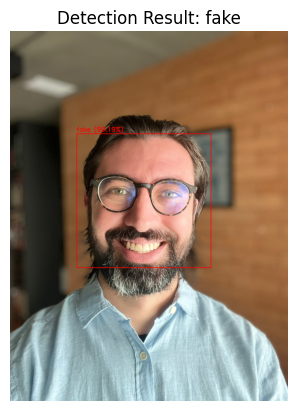

In [32]:
# Função de detecção de vivacidade
def detect_liveness(image, model):
    if image is None:
        print("Erro: Imagem não carregada corretamente.")
        return None, 'Erro ao carregar imagem'

    # Detectar a face na imagem
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        # Se nenhuma face for detectada, adicionar etiqueta "falso"
        cv2.putText(image, 'fake', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
        return image, 'fake'
    else:
        for (x, y, w, h) in faces:
            face = image[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (img_width, img_height)) / 255.0
            face_resized = np.expand_dims(face_resized, axis=0)
            prediction = model.predict(face_resized)
            label = 'real' if np.argmax(prediction) == 1 else 'fake'
            confidence = np.max(prediction)

            # Desenhar a caixa ao redor da face e adicionar a etiqueta
            color = (0, 255, 0) if label == 'real' else (0, 0, 255)
            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
            cv2.putText(image, f'{label} ({confidence*100:.2f}%)', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        return image, label

# Teste com uma nova imagem
test_image_path = 'testes/img_1.jpeg'
test_image = cv2.imread(test_image_path)

# Verificar se a imagem foi carregada corretamente
if test_image is None:
    print("Erro: Imagem não encontrada ou caminho incorreto.")
else:
    result_image, result_label = detect_liveness(test_image, model)

    # Converter BGR para RGB para exibição
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

    # Exibir a imagem e o resultado
    plt.imshow(result_image_rgb)
    plt.axis('off')
    plt.title(f'Detection Result: {result_label}')
    plt.show()